# FPSB with Revenue Equivalence: Simpler Version

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import seaborn as sns
from scipy import interpolate 

# for plots 
# plt.rcParams.update({"text.usetex": True, 'font.size':14})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ensuring this notebook generates the same answers 
np.random.seed(1337)

# Known distribution 

In [2]:
R = 100_000
n = 5
np.random.seed(1337)
F_draw = lambda size : np.random.chisquare(df=2, size=size)
F_cdf  = lambda x : stats.chi2.cdf(x, df=2)
F_pdf  = lambda x : stats.chi2.pdf(x, df=2)

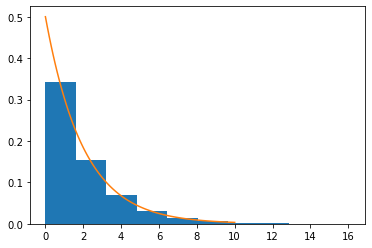

In [3]:
xx = np.linspace(0,10,100)
yy = F_pdf(xx)
vv = F_draw(10_000)
plt.hist(vv, density=True);
plt.plot(xx,yy);

# Drawing from a truncated distribution

In [4]:
def draw_from_truncated(F_draw, vbar, n, R): 
    assert vbar > 0.0, f'Cannot draw from a truncated distribution with vbar={vbar}: no observations'
    desired_size = n*R

    # how many extra draws are required? 
    extra_draws = 1.0 / F_cdf(vbar) * 1.1 # 10% more just to be sure 
    largenum = np.round(desired_size*extra_draws).astype(int)

    # draw 
    v_untrunc = F_draw(size=(largenum,))

    # perform truncation
    v_trunc = v_untrunc[(v_untrunc <= vbar)].copy()

    # drop excess rows so we have a regular array
    drop_this_many = np.mod(v_trunc.size, n)
    if drop_this_many != 0: 
        v_trunc = v_trunc[:-drop_this_many]

    # regularize array
    v_sim = v_trunc.reshape(n, -1)

    return v_sim 

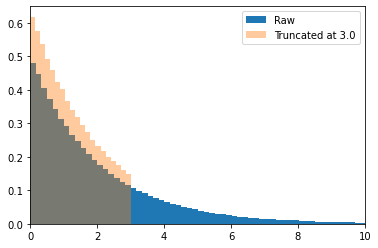

In [5]:
# raw 
v = F_draw(size=(n*R,))
plt.hist(v.flatten(), bins=200, density=True, label='Raw');

# truncated
vbar = 3.
vsim = draw_from_truncated(F_draw, vbar, n=n, R=R)
plt.hist(vsim.flatten(), bins=20, density=True, label=f'Truncated at {vbar}', alpha=0.4);

plt.xlim(0,10);
plt.legend();


## Solve for the BNE of the First Price Sealed Bid (FPSB) auction

In [6]:
def b_star(v): 
    if v == 0.0: 
        return 0.0
    v_losers = draw_from_truncated(F_draw, vbar=v, n=n-1, R=R)
    vmax = v_losers.max(axis=0)
    Ev_2nd = np.mean(vmax)
    return Ev_2nd

In [7]:
b_star(1.1)

0.83557726572989

In [8]:
v = 5.1
bid_shading = b_star(v)/v
print(f'Bidders should bid {bid_shading: 5.2%} of their valuation at {v=: 5.2f}')

Bidders should bid  58.71% of their valuation at v= 5.10


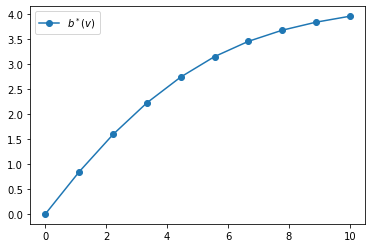

In [9]:
xx = np.linspace(0, 10, 10)
yy = np.array([b_star(v) for v in xx])
plt.plot(xx, yy, '-o', label='$b^*(v)$');
plt.legend();

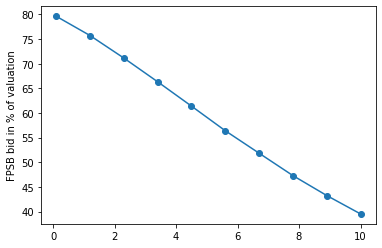

In [10]:
xx = np.linspace(0.1, 10, 10)
yy = np.array([b_star(v)/v*100.0 for v in xx])
plt.plot(xx, yy, '-o');
plt.ylabel('FPSB bid in % of valuation');